## **DATA PREPROCESSING**: IMAGE SYNTHESIS

From the dataset of _60_ images that we have fetched from the Google Street Views API, we now need to make this dataset as big as we can in order to feed our model

### Imports, globals and requirements

In [1]:
%%bash
[[ ! -e /colabtools ]] && exit
mounting_folder = "/content/drive/"

root_folder = "MyDrive/Mejora la red de bici Madrid/"


data_folder = "data/"
working_folder = 'data_adquisition_gsm_api/'
metadata_folder = 'gsv_images/'

_pwd = f"{mounting_folder}{root_folder}{working_folder}"

In [ ]:
%%bash
[[  -e /colabtools ]] && exit

data_folder = "../data/"
working_folder = 'img_prep/'
metadata_folder = 'gsv_images/'
metadata_folder = 'gsv_meta/'

_pwd = f"{mounting_folder}{root_folder}{working_folder}"

In [2]:
%%bash
[[ ! -e /colabtools ]] && exit

!pip install -r "$_pwd"requirements.txt

In [3]:
%%bash
[[ ! -e /colabtools ]] && exit

from google.colab import drive
drive.mount(mounting_folder)

In [4]:
import json
import geopandas  as gpd
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import numpy  as np
import pandas as pd

from glob import glob
from os  import path, listdir
from re  import findall
from PIL import Image
from pprint import pprint
from typing import Generator, List
from shapely import wkt

### EDA GSV Data: 
* Image color histogram: viz and normalization
* Filtering imgs that are outliers in the content
* Pixel size vs Image size

* Image sinthesis: how to categorize the data so that its variability is still meaninful?


In [156]:
metadata_folder = f"{_pwd}gsv_imgs"

def get_files_from_dir(input_dir:str, fext:str='.json') -> Generator:
    """ Given a input directory and a target file extension,
    parses all the files and yields their content

    Args:
        input_dir (str): directory where the files to files 
            are stored.
        fext (str): file extension to parse. JSON expected 

    Yields:
        parsed data
    """ 
    input_dir += '/' if not input_dir.endswith('/') else ''
    
    for fname in glob(f"{input_dir}*{fext}"):

        jsonf_path = path.join(input_dir, fname)

        if fext == '.json':
            with open(jsonf_path, 'r') as fjson:
                yield fname.split('/')[-1], json.load(fjson)

        elif fext == '.jpg':
            yield fname.split('/')[-1], np.asarray(Image.open(fname))



def tuplegen_to_dict(tuple_gen:Generator):
    """ Takes a generator of an iterator of tuples to a dict
    """ 
    return {t[0]: t[1] for t in list(tuple_gen)}  # [(k,v) .. (k,v)] -> {k:v}


def categorize_data(data:Generator, headers:list) -> List[dict]:
    """ There are two types of data stored in the folder:
      - Header data
      - Meta   data

    They have different keys(), therefore we need to separated 
    them to concat them when making a dataframe.

    Args:
        data (generator): dictionary like generator that has the
            data parsed.
    
    Returns:
        tuple with two dictionaries, header and meta information
    """
    format_key = lambda k: "_".join(findall("(?<=_)(.*)(?=.json)", k))\
                              .replace(' ', '_')

    d_files = tuplegen_to_dict(data)  # [(k,v) .. (k,v)] -> {k:v}

    for item in headers:
        yield {format_key(k):v for k, v in d_files.items() if k.startswith(item)}


In [7]:
list_of_data = list(categorize_data(
      data = get_files_from_dir(input_dir=metadata_folder),
      headers = ["header", "meta"]
))

# Printing the first key for both 
pprint(next(iter(list_of_data[0].items()))); print()
pprint(next(iter(list_of_data[1].items())))

('40.43509732_-3.70859088',
 {'Access-Control-Allow-Origin': '*',
  'Age': '6132',
  'Cache-Control': 'public, max-age=86400',
  'Content-Length': '110268',
  'Content-Type': 'image/jpeg',
  'Date': 'Tue, 10 May 2022 17:48:39 GMT',
  'Expires': 'Wed, 11 May 2022 17:48:39 GMT',
  'Server': 'scaffolding on HTTPServer2',
  'Server-Timing': 'gfet4t7; dur=1',
  'X-Frame-Options': 'SAMEORIGIN',
  'X-XSS-Protection': '0'})

('40.43509732_-3.70859088',
 {'copyright': '© Google',
  'date': '2021-09',
  'location': {'lat': 40.43511422541308, 'lng': -3.708579822966505},
  'pano_id': '7t9boecT-kDj6lUdEg-9cw',
  'status': 'OK'})


In [8]:
meta = pd.concat([pd.DataFrame.from_dict(d, orient='index') for d in list_of_data], axis = 1).reset_index(drop=True)

* Now that we have the dataset, we clean it: 
  - There are nulls in the dataset (in both axis)
  - There seams to be some columns with only one value 

In [11]:
def drop_columns_with_one_val(frame):
    """ If there is only one unique value in a columns, that columns is 
    drop since it doens't add any information of data.

    It also takes the cases where all the values a none, so it purges
    the dataframe in the axis = 1.

    Args:
        df: initial dataframe
    
    Returns:
        df: purged dataframe
    """
    for col in frame.columns:
        if len(frame[col].value_counts().index) == 1:
            frame.drop(columns=col, inplace =True)

    return frame


def get_latlon(cell):
    """ In the metadata, the lat lon is given a a dictionary such as:

        'location' -> {'lat': ...., 'lng': ...... }

    This function takes the lat lon of the dictionary, creates Well known Text
    representation of the geometry and return its parsing into a geometry obj.

    WKT info: 
       https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry
       https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.from_wkt.html

    Args:
        ser: pandas series -> df[col]
    
    Returns:
        tuple of two series, one for lat(Y) and the other for long (X)
    """
    if isinstance(cell, dict):
        lat =  cell['lat']
        lon =  cell['lng']
    else:
        raise TypeError

    # conversion to WKT
    wkt_geom = f"POINT ({lon} {lat})"
    return wkt.loads(wkt_geom)

In [12]:
meta = drop_columns_with_one_val(meta)

meta['geometry'] = meta['location'].apply(get_latlon)
meta.drop(columns='location', inplace=True)

meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Content-Length  49 non-null     object
 1   Date            49 non-null     object
 2   Expires         49 non-null     object
 3   Age             48 non-null     object
 4   Server-Timing   49 non-null     object
 5   copyright       49 non-null     object
 6   date            49 non-null     object
 7   pano_id         49 non-null     object
 8   geometry        49 non-null     object
dtypes: object(9)
memory usage: 3.6+ KB


In [13]:
meta.head(2)

,Content-Length,Date,Expires,Age,Server-Timing,copyright,date,pano_id,geometry
0,110268,"Tue, 10 May 2022 17:48:39 GMT","Wed, 11 May 2022 17:48:39 GMT",6132,gfet4t7; dur=1,© Google,2021-09,7t9boecT-kDj6lUdEg-9cw,POINT (-3.708579822966505 40.43511422541308)
1,101362,"Tue, 10 May 2022 17:48:39 GMT","Wed, 11 May 2022 17:48:39 GMT",6132,gfet4t7; dur=2,© Google,2022-03,Ubkovxmyv0wkrfX9EnrYMg,POINT (-3.707158098691492 40.43154187329881)


* Let's check images that are not produced by google.

In [15]:
meta[meta['copyright'] != '© Google']

,Content-Length,Date,Expires,Age,Server-Timing,copyright,date,pano_id,geometry
12,55849,"Tue, 10 May 2022 19:30:52 GMT","Wed, 11 May 2022 19:30:52 GMT",1,gfet4t7; dur=1,© Konrad Steyn,2015-08,CAoSLEFGMVFpcFA1Wm9wRFJLQUUwakpyVWtMNjlVM0dURk...,POINT (-3.7033608 40.4169006)
21,121500,"Tue, 10 May 2022 17:48:48 GMT","Wed, 11 May 2022 17:48:48 GMT",6126,gfet4t7; dur=1,© Lars Bakka,2020-02,CAoSLEFGMVFpcE43ZVIzeWdJak9FNTF2d0RZTmVOS3VMOU...,POINT (-3.708771 40.41596740000001)
24,64851,"Tue, 10 May 2022 19:30:55 GMT","Wed, 11 May 2022 19:30:55 GMT",1,gfet4t7; dur=2,© Foto Video Vergara,2019-10,CAoSLEFGMVFpcE5jLUFHVWdIRzZlXzVLRFdCTFVzaE5fRj...,POINT (-3.6987347 40.4349359)
25,65702,"Tue, 10 May 2022 17:48:52 GMT","Wed, 11 May 2022 17:48:52 GMT",6123,gfet4t7; dur=1,© Ad & Fancy,2017-10,CAoSLEFGMVFpcFBMQ0RIRVlsRWNGMmxiX3NLLVRYU3JyWk...,POINT (-3.6964465 40.4186743)


In [16]:
meta['date'].value_counts().sort_index(ascending=False)

2022-04     6
2022-03    16
2022-02     2
2022-01     4
2021-09     4
2021-08     2
2021-07     3
2021-05     1
2020-02     1
2019-10     1
2019-08     3
2019-05     1
2019-01     1
2017-10     1
2017-09     1
2017-06     1
2015-08     1
Name: date, dtype: int64

In [17]:
print(meta['Content-Length'].max())
print(meta['Content-Length'].min())

99683
100065


* Conclusions from the meta data:

  - There is no information to filter tunnels from there,but it is possible to filter user-uploaded photos.
  - The date where the images were produces ranges within a 5y range, and all seasons.
  

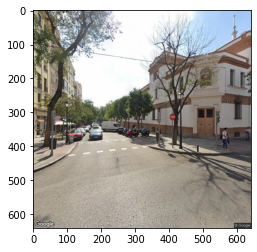

In [174]:
### Abrimos las imágenes

imgs = tuplegen_to_dict(get_files_from_dir(input_dir=metadata_folder, fext='.jpg'))

plt.imshow(Image.fromarray(next(iter(imgs.values()))))

In [173]:
imgs_arr_df = pd.DataFrame.from_records(list(imgs.items()))
imgs_arr_df.shape

(49, 2)

In [175]:
imgs_arr_df.head(1)

,0,1
0,pic_40.43509732 -3.70859088.jpg,"[[[173, 170, 153], [199, 196, 177], [150, 148,..."


In [176]:
meta = pd.concat([pd.DataFrame.from_dict(d, orient='index') for d in list_of_data], axis = 1).reset_index(drop=True)

meta.head(1)

,Access-Control-Allow-Origin,Server,Content-Length,X-XSS-Protection,X-Frame-Options,Date,Expires,Cache-Control,Content-Type,Age,Server-Timing,copyright,date,location,pano_id,status
0,*,scaffolding on HTTPServer2,110268,0,SAMEORIGIN,"Tue, 10 May 2022 17:48:39 GMT","Wed, 11 May 2022 17:48:39 GMT","public, max-age=86400",image/jpeg,6132,gfet4t7; dur=1,© Google,2021-09,"{'lat': 40.43511422541308, 'lng': -3.708579822...",7t9boecT-kDj6lUdEg-9cw,OK
